In [1]:
import copy
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

from astropy.io import ascii
from datetime import datetime
from mpl_toolkits.basemap import Basemap, solar
from matplotlib.colors import ListedColormap
from pyhdf.SD import SD, SDC 
from scipy import stats

from func import *   # local functions

This notebook will be used to figure out how to reduce data for other times in the night (start and end points of observation periods).

In [2]:
# initialize our various terminators

dat_2120 = datetime(2013,5,18,21,20,0)
dat_0032 = datetime(2013,5,19,0,32,0)

dat_2132 = datetime(2013,5,18,21,32,0)
dat_2305 = datetime(2013,5,18,23,5,0)

dat_2308 = datetime(2013,5,18,23,8,0)
dat_0001 = datetime(2013,5,19,0,1,0)

dats = [dat_2120, 
        dat_0032, 
        dat_2132, 
        dat_2305, 
        dat_2308, 
        dat_0001]

# --------------------------------- #

daynight_2120 = terminator(dat_2120)
daynight_0032 = terminator(dat_0032)

daynight_2132 = terminator(dat_2132)
daynight_2305 = terminator(dat_2305)

daynight_2308 = terminator(dat_2308)
daynight_0001 = terminator(dat_0001)

# -------------------------------- #

# Test the dt function

fmt = '%Y-%m-%d %H:%M:%S'
d1 = datetime.strptime(str(dat_2120), fmt)
d2 = datetime.strptime(str(dat_2305), fmt)

# Convert to Unix timestamp
d1_ts = time.mktime(d1.timetuple())
d2_ts = time.mktime(d2.timetuple())

# They are now in seconds, subtract and then divide by 60 to get minutes.
print int(d2_ts-d1_ts) / 60

105


This gives me a way to determine the center and edges of visible disk from the time in UT alone, so I will make a function which does just this. This will then be implemented in functions similar to cot_ctp and landcover. I might merge these together, by having the inputs be dictionaries which specify the land, snow, and atmosphere SDS's and files

In [3]:
def delta_deg(dt):
    
    '''
    Finds the center of view, western edge, and eastern edge of the disk of Earth as viewed from
    the moon at a particular time. This is achieved using the change in time from 21:20 UT on 
    5/18/2013.
    
    INPUTS: dt - float or int, change in time from 21:20 UT on 5/18/2013.
    
    OUTPUTS: center (float) - central longitude value for use in Basemap plotting
             west_edge (np.array) - 2D array of lat/lon values west of the western edge of Earth disk
             east_edge (np.array) - 2D array of lat/lon values east of the eastern edge of Earth disk
    '''
    
    lon0 = -39.8333   # center of disk at 21:20
    
    center = lon0 - (0.25*dt)   # center of disk at new time
    
    west = center - 90    # west edge of disk
    east = center + 90    # east edge of disk
    
    www = (west + 180) / 2    # convert to a value in the 90x180 array
    eee = (east + 180) / 2
    
    if www - (int(www) + 0.5) < 0:       # This rounds each edge value and coerces it
        wedge = int((west + 180) / 2)    # to be an integer
        eedge = int((east + 180) / 2)
    else:
        wedge = int(math.ceil(www))
        eedge = int(math.ceil(eee))
    
    west_edge = range(0, wedge)    # create arrays for values which are not visible
    east_edge = range(eedge, 180)
    
    return center, west_edge, east_edge

'''
lon_0032, west, east = delta_deg(192)
print lon_0032, west, east
'''
lon_2120, west_2120, east_2120 = delta_deg(0)
print lon_2120, west_2120, east_2120


delta_deg(192)    # 2132

delta_deg(12)    # 2132
delta_deg(105)    # 2305

delta_deg(108)    # 2308
delta_deg(161)    # 0001


-39.8333 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] [115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]


(-80.08330000000001,
 [0, 1, 2, 3, 4],
 [95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  179])

In [3]:
def timediffs(date):
    
    '''
    Finds the center of view, western edge, and eastern edge of the disk of Earth as viewed from
    the moon at a particular time. This is achieved using the change in time from 21:20 UT on 
    5/18/2013.
    
    INPUTS: date - datetime object (datetime(year,month,day,hour,min,sec))
    
    OUTPUTS: center (float) - central longitude value for use in Basemap plotting
             west_edge (np.array) - 2D array of lat/lon values west of the western edge of Earth disk
             east_edge (np.array) - 2D array of lat/lon values east of the eastern edge of Earth disk
    '''
    
    date0 = datetime(2013,5,18,21,20,0)    # 21:20
    lon0 = -39.8333                        # center of disk at 21:20
    
    ### FINDING TIME DIFFERENCE IN MINUTES
    
    fmt = '%Y-%m-%d %H:%M:%S'
    d1 = datetime.strptime(str(dat_2120), fmt)
    d2 = datetime.strptime(str(date), fmt)

    # Convert to Unix timestamp
    d1_ts = time.mktime(d1.timetuple())
    d2_ts = time.mktime(d2.timetuple())

    # They are now in seconds, subtract and then divide by 60 to get minutes.
    dt = int(d2_ts-d1_ts) / 60
    
    ### FINDING CENTER & EDGES OF DISK
    
    center = lon0 - (0.25*dt)   # center of disk at new time
    
    west = center - 90    # west edge of disk
    east = center + 90    # east edge of disk
    
    www = (west + 180) / 2    # convert to a value in the 90x180 array
    eee = (east + 180) / 2
    
    if www - (int(www) + 0.5) < 0:       # This rounds each edge value and coerces it
        wedge = int((west + 180) / 2)    # to be an integer
        eedge = int((east + 180) / 2)
    else:
        wedge = int(math.ceil(www))
        eedge = int(math.ceil(eee))
    
    west_edge = range(0, wedge)    # create arrays for values which are not visible
    east_edge = range(eedge, 180)
    
    return center, west_edge, east_edge

Now that I have completed this function, I check for bugs

C:\Users\Nick\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
C:\Users\Nick\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\Nick\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
C:\Users\Nick\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\Nick\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Cha

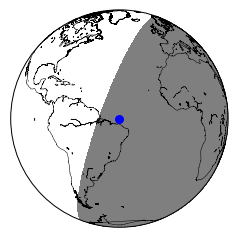

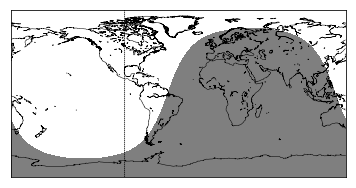

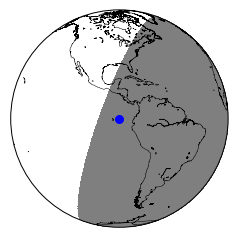

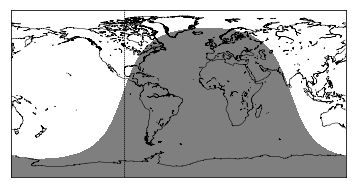

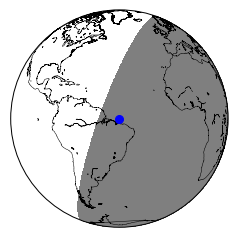

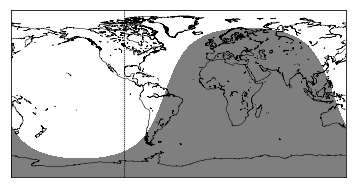

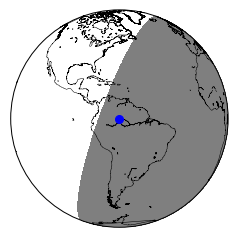

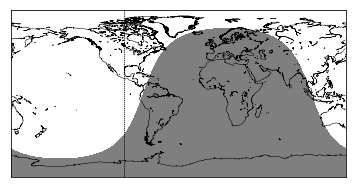

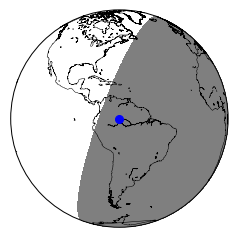

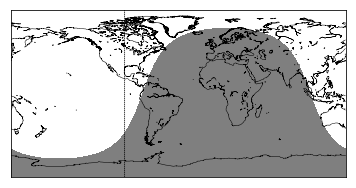

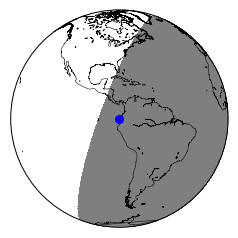

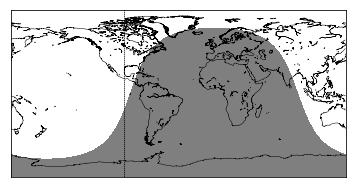

In [5]:
def earthpics(dats):
    
    for i in dats:
        
        center, west_edge, east_edge = timediffs(i)
        
        m = Basemap(projection='ortho', resolution='l', lat_0=0, lon_0 = center)
        m.drawcoastlines(linewidth=0.5)
        #m.drawparallels([-75.2], labels=[1])
        #m.drawmeridians([west, east], color='red', markersize=8, labels=[1])

        lon = center
        lat = 0.
        xx,yy = m(lon, lat)
        m.plot(xx, yy, 'bo', markersize=8)

        CS = m.nightshade(i)
        plt.show()
        
        m = Basemap(projection='cyl', resolution='l', lat_0=0, lon_0 = -39.83)
        m.drawcoastlines(linewidth=0.5)
        m.drawmeridians([-97.43], labels=[1])

        CS = m.nightshade(i)
        plt.show()
        
plt.show()
earthpics(dats)

I believe that these are ready to implement into the code, so I will now construct a frankenfunction to test this out.

#### First, Land

In [4]:
def date_reduce_land(landfile, snowfile, landsds_name, snowsds_name, date, in_res = 0.05):
    
    '''
    
    '''
    
    itdat = range(90)      # used for iterating through cot and ctp data
    itdat2 = range(180)
    

    #----------SNOW DATA-----------------#
    snowhdf = SD(snowfile, SDC.READ) 
    snowsds = snowhdf.select(snowsds_name)
    snowvals = np.array(snowsds.get())


    #----------LAND DATA-----------------#
    landhdf = SD(landfile, SDC.READ) 
    landsds = landhdf.select(landsds_name)
    landvals = np.array(landsds.get())
    
    print type(landvals), type(snowvals)

    landmodes = submatrx_mode(landvals, in_res)   # rebins yearly data to 2x2
    snowmodes = submatrx_mode(snowvals, in_res)   # rebins daily data to 2x2

    landcover = modismap(landmodes)  # remaps integer values the to 5 values of land cover in our model
    
    print type(landcover)
        
    daynight = terminator(date)

    for i in range(len(snowmodes[0:74])):
        for j in range(len(snowmodes[i])):                          # this is the world above lat -60 deg.
            if (snowmodes[i][j] > 0) and (snowmodes[i][j] <= 100):

                landcover[i][j] = 5   # this changes snow values to value corresponding to snow in land data

    for i in range(len(daynight)):
        for j in range(len(daynight[i])):
            if daynight[i][j] == 1.0:
                landcover[i][j] = np.nan   # this changes values of unlit parts of earth to NaN
    '''
    west_edge = range(0,26)
    east_edge = range(115,180)    # these are the edges of the Earth's disk as seen from the moon
    '''                              # on the night of observation at 21:20 UT
    
    center, west_edge, east_edge = timediffs(date)

    # makes values None outside of lon range

    for i in itdat:
        for j in west_edge:
            landcover[i][j] = np.nan    # this changes values of unseen parts of earth to NaN

    for i in itdat:
        for j in east_edge:
            landcover[i][j] = np.nan    # this changes values of unseen parts of earth to NaN
            
    return np.array(landcover), center

#### Now, Clouds

In [7]:
def date_reduce_clouds(cloudfile, sdslist, ctpbins, cotbins, date, is_ctp = True):
    
    # opens hdf file, gets the SDS's
    hdf, sds = getSDS(cloudfile, sdslist)

    cot = sds[0]   # cloud optical thickness
    ctp = sds[1]   # cloud top pressure
    
    itdat = range(90)   # used for iterating through cot and ctp data
    itdat2 = range(180)
    
    # rebins array shape of both to 2 x 2 degrees
    cot = binavg(cot,1) 
    ctp = binavg(ctp,1)   

    if is_ctp == True:    
        ctp *= 0.001   # converts from hPa to bars
    
    ctp = rebindat(ctp, ctpbins)   # rebins ctp values to desired bins
    cot = rebindat(cot, cotbins)
    
    daynight = terminator(date)
    
    center, west_edge, east_edge = timediffs(date)

    # makes values None outside of lon range

    for i in itdat:
        for j in west_edge:
            cot[i][j] = np.nan
            ctp[i][j] = np.nan    # this changes values of unseen parts of earth to NaN

    for i in itdat:
        for j in east_edge:
            cot[i][j] = np.nan
            ctp[i][j] = np.nan    # this changes values of unseen parts of earth to NaN
    
    for i in range(len(daynight)):
        for j in range(len(daynight[i])):
            if daynight[i][j] == 1.0:
                cot[i][j] = np.nan
                ctp[i][j] = np.nan    # this changes values of unlit parts of earth to NaN
                
    return ctp, cot

### Now, for plotting

In [8]:
# initialize the constant variables

snowfile = '../MYD10C1_5.18.2013.hdf'    # Daily global snow cover, 0.05 x 0.05 degree average
snowsds_name = 'Day_CMG_Snow_Cover'

landfile = '../MCD12C1.2013.hdf'        # Yearly global land cover, 0.05 x 0.05 degree average
landsds_name = 'Majority_Land_Cover_Type_1'

cloudfile = '../MYD08_D3_5.18.13.hdf'   # Daily global cloud profile, 

cloud_sds = ['Cloud_Optical_Thickness_16_Liquid_Mean',     # Use mean 1.6 micron COT data
             'Cloud_Top_Pressure_Mean']                    # Use mean combined wavelength CTP     

ctp_bins = [0.0000003, 0.025, 0.189, 0.213, 0.238, 0.268, 0.299, 0.332,    # bins for values of 
             0.372, 0.411, 0.554, 0.591, 0.628, 0.710, 0.902, 1.03]        # cloud top pressure

cot_bins = [0,2,4,6,8,10,12,14,16,18,20,25,30,35,40,52,64,76,88,100]   # bins of cloud optical thickness values

cot_bins_crude = [0, 2, 5, 10, 15, 20, 25, 30, 35, 40, 52, 64, 76, 88, 100]   # cloud optical thickness bins
                                                                              # with fewer values between 0-20
    
my_cmap = ListedColormap(['xkcd:black',
                       'xkcd:royal blue',
                       'xkcd:forest green',
                       'xkcd:green',
                       'xkcd:beige',
                       'xkcd:white'])

In [9]:
# find arrays for 00:32

land, center = date_reduce_land(landfile, snowfile, landsds_name, snowsds_name, dat_0032)   # create land array

ctp, cot = date_reduce_clouds(cloudfile, cloud_sds, ctp_bins, cot_bins, dat_0032)      # create ctp and cot arrays

combos = unique_combos(land, cot, ctp)   # find unique combinations of land type, COT, and CTP

<type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>


func.py:91: RuntimeWarning: Mean of empty slice
  binned.append(np.nanmean(catch))   # finds mean of all values within a bin


In [33]:
print np.shape(ctp), np.shape(cot)

(90L, 180L) (90L, 180L)


#### CTP

                Geostationary, Orthographic or Azimuthal equidistant basemap
                

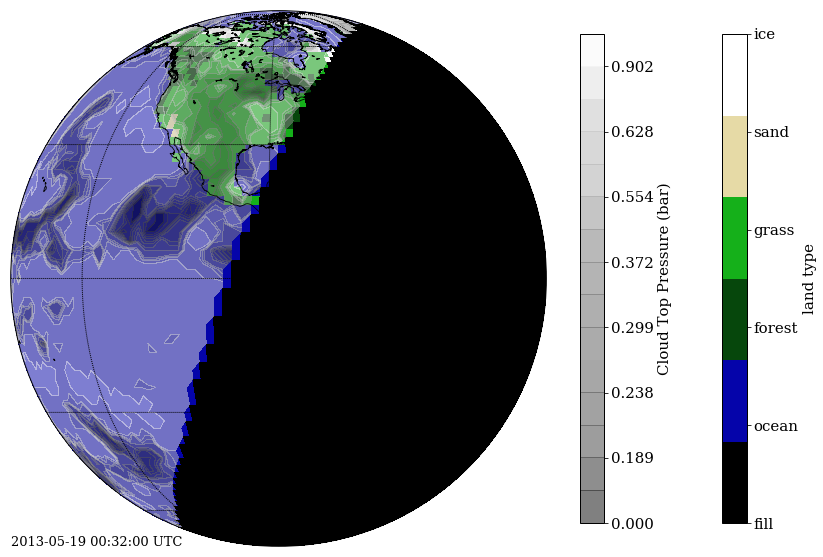

In [23]:
fig = plt.figure(figsize=(15,15))
    
plt.rc('font', family='serif', weight = 545, size = 15)

m = Basemap(projection='ortho', resolution='l', lat_0=0, lon_0 = center)

m.drawcoastlines(linewidth=0.8)
m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])

lat = np.arange(-90,89,2)
lon = np.arange(-180,180,2)

x, y = m(*np.meshgrid(lon, lat))

ax1 = m.pcolor(x, y, land[::-1], cmap=plt.cm.get_cmap(my_cmap,6))

plt.clim(0,5)

cbar = plt.colorbar(ax1, label='land type', orientation='vertical', ticks=range(6), shrink = 0.6)
cbar.outline.set_edgecolor('xkcd:black')
cbar.outline.set_linewidth(1)
cbar.ax.set_yticklabels(['fill', 'ocean', 'forest', 'grass', 'sand', 'ice'], {'fontsize':15})
cbar.outline.set_label({'fontsize':15})

ax2 = m.contourf(x, y, ctp[::-1], levels = ctp_bins, alpha = 0.5, cmap='Greys_r')

contour_bar = plt.colorbar(ax2, label = 'Cloud Top Pressure (bar)', orientation='vertical', shrink = 0.6)
contour_bar.outline.set_edgecolor('xkcd:black')
contour_bar.outline.set_linewidth(1)

plt.text(0,0,'{} UTC'.format(dat_0032), {'fontsize':13})

#plt.title('{} UTC'.format(dat_0032), {'fontsize':15})

plt.show()

#### COT

                Geostationary, Orthographic or Azimuthal equidistant basemap
                

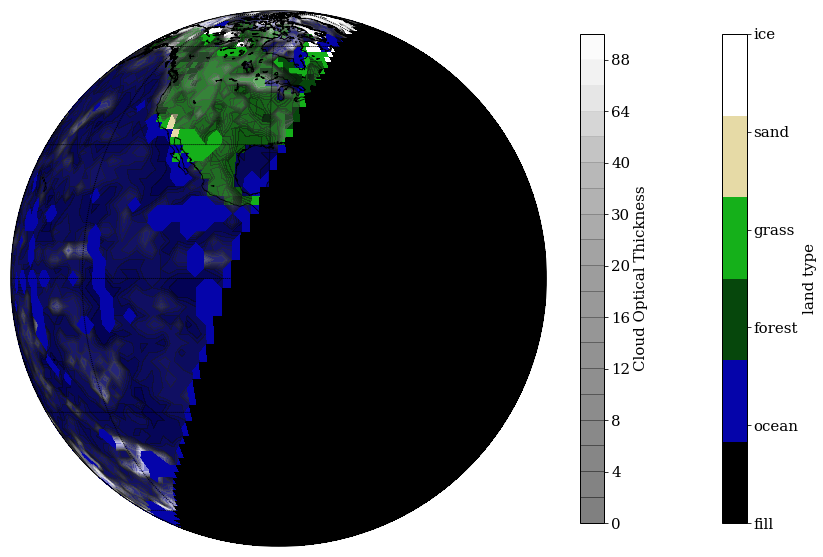

In [11]:
fig = plt.figure(figsize=(15,15))
    
plt.rc('font', family='serif', weight = 545, size = 15)

m = Basemap(projection='ortho', resolution='l', lat_0=0, lon_0 = center)

m.drawcoastlines(linewidth=0.8)
m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])

lat = np.arange(-90,89,2)
lon = np.arange(-180,180,2)

x, y = m(*np.meshgrid(lon, lat))

ax1 = m.pcolor(x, y, land[::-1], cmap=plt.cm.get_cmap(my_cmap,6))

plt.clim(0,5)

cbar = plt.colorbar(ax1, label='land type', orientation='vertical', ticks=range(6), shrink = 0.6)
cbar.outline.set_edgecolor('xkcd:black')
cbar.outline.set_linewidth(1)
cbar.ax.set_yticklabels(['fill', 'ocean', 'forest', 'grass', 'sand', 'ice'], {'fontsize':15})
cbar.outline.set_label({'fontsize':15})

ax2 = m.contourf(x, y, cot[::-1], levels = cot_bins, alpha = 0.5, cmap='Greys_r')

contour_bar = plt.colorbar(ax2, label = 'Cloud Optical Thickness', orientation='vertical', shrink = 0.6)
contour_bar.outline.set_edgecolor('xkcd:black')
contour_bar.outline.set_linewidth(1)

#plt.title('2x2 Degree Land Cover of Earth as Seen from the Moon w/ Cloud Top Pressure - 5/18/13 21:20 UTC', {'fontsize':15})

plt.show()

Penultimately, I make ascii tables of all of these land, ctp, and cot datasets for each time.

In [23]:
def export_data(date_list, name_list):
    
    for i, val in enumerate(date_list):
        
        land, center = date_reduce_land(landfile, snowfile, landsds_name, snowsds_name, val)   # create land array
        ctp, cot = date_reduce_clouds(cloudfile, cloud_sds, ctp_bins, cot_bins, val)      # create ctp and cot arrays
        
        ascii.write(ctp.T, 'ctp_{}.txt'.format(name_list[i]))
        ascii.write(cot.T, 'cot_{}.txt'.format(name_list[i]))
        ascii.write(land.T, 'land_{}.txt'.format(name_list[i]))

name_list = ['0.4-0.9_start',
             '0.4-0.9_end',
             '0.9-1.5_start',
             '0.9-1.5_end',
             '1.4-2.4_start',
             '1.4-2.4_end']

export_data(dats, name_list)

<type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>


<type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>


In [25]:
def export_plots_cot(date_list, name_list):
    
    for i, val in enumerate(date_list):
        
        land, center = date_reduce_land(landfile, snowfile, landsds_name, snowsds_name, val)   # create land array
        ctp, cot = date_reduce_clouds(cloudfile, cloud_sds, ctp_bins, cot_bins, val)      # create ctp and cot arrays
        
        fig = plt.figure(figsize=(15,15))
    
        plt.rc('font', family='serif', weight = 545, size = 15)

        m = Basemap(projection='ortho', resolution='l', lat_0=0, lon_0 = center)

        m.drawcoastlines(linewidth=0.8)
        m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])

        lat = np.arange(-90,89,2)
        lon = np.arange(-180,180,2)

        x, y = m(*np.meshgrid(lon, lat))

        ax1 = m.pcolor(x, y, land[::-1], cmap=plt.cm.get_cmap(my_cmap,6))

        plt.clim(0,5)

        cbar = plt.colorbar(ax1, label='land type', orientation='vertical', ticks=range(6), shrink = 0.6)
        cbar.outline.set_edgecolor('xkcd:black')
        cbar.outline.set_linewidth(1)
        cbar.ax.set_yticklabels(['fill', 'ocean', 'forest', 'grass', 'sand', 'ice'], {'fontsize':15})
        cbar.outline.set_label({'fontsize':15})
        
        ax2 = m.contourf(x, y, cot[::-1], levels = cot_bins, alpha = 0.5, cmap='Greys_r')

        contour_bar = plt.colorbar(ax2, label = 'Cloud Optical Thickness', orientation='vertical', shrink = 0.6)
        contour_bar.outline.set_edgecolor('xkcd:black')
        contour_bar.outline.set_linewidth(1)

        plt.savefig('landcover_cot_{}.pdf'.format(name_list[i]))
        
export_plots_cot(dats, name_list)

<type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>
                Geostationary, Orthographic or Azimuthal equidistant basemap
                <type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>
                Geostationary, Orthographic or Azimuthal equidistant basemap
                <type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>
                Geostationary, Orthographic or Azimuthal equidistant basemap
                <type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>
                Geostationary, Orthographic or Azimuthal equidistant basemap
                <type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>
                Geostationary, Orthographic or Azimuthal equidistant basemap
                <type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>
                Geostationary, Orthographic or Azimuthal equidistant basemap
                

In [26]:
def export_plots_ctp(date_list, name_list):
    
    for i, val in enumerate(date_list):
        
        land, center = date_reduce_land(landfile, snowfile, landsds_name, snowsds_name, val)   # create land array
        ctp, cot = date_reduce_clouds(cloudfile, cloud_sds, ctp_bins, cot_bins, val)      # create ctp and cot arrays
        
        fig = plt.figure(figsize=(15,15))
    
        plt.rc('font', family='serif', weight = 545, size = 15)

        m = Basemap(projection='ortho', resolution='l', lat_0=0, lon_0 = center)

        m.drawcoastlines(linewidth=0.8)
        m.drawparallels(np.arange(-90., 120., 30.), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180., 181., 45.), labels=[0, 0, 0, 1])

        lat = np.arange(-90,89,2)
        lon = np.arange(-180,180,2)

        x, y = m(*np.meshgrid(lon, lat))

        ax1 = m.pcolor(x, y, land[::-1], cmap=plt.cm.get_cmap(my_cmap,6))

        plt.clim(0,5)

        cbar = plt.colorbar(ax1, label='land type', orientation='vertical', ticks=range(6), shrink = 0.6)
        cbar.outline.set_edgecolor('xkcd:black')
        cbar.outline.set_linewidth(1)
        cbar.ax.set_yticklabels(['fill', 'ocean', 'forest', 'grass', 'sand', 'ice'], {'fontsize':15})
        cbar.outline.set_label({'fontsize':15})

        ax2 = m.contourf(x, y, ctp[::-1], levels = ctp_bins, alpha = 0.5, cmap='Greys_r')

        contour_bar = plt.colorbar(ax2, label = 'Cloud Top Pressure (bar)', orientation='vertical', shrink = 0.6)
        contour_bar.outline.set_edgecolor('xkcd:black')
        contour_bar.outline.set_linewidth(1)
        
        plt.savefig('landcover_ctp_{}.pdf'.format(name_list[i]))
        
export_plots_ctp(dats, name_list)

<type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>
                Geostationary, Orthographic or Azimuthal equidistant basemap
                <type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>
                Geostationary, Orthographic or Azimuthal equidistant basemap
                <type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>
                Geostationary, Orthographic or Azimuthal equidistant basemap
                <type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>
                Geostationary, Orthographic or Azimuthal equidistant basemap
                <type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>
                Geostationary, Orthographic or Azimuthal equidistant basemap
                <type 'numpy.ndarray'> <type 'numpy.ndarray'>
<type 'list'>
                Geostationary, Orthographic or Azimuthal equidistant basemap
                